### Case Study: Credit Underwriting and Analysis

A credit company acquires applicants for credit. These applicants apply for credit, and the company decides whether to issue credit.

Using historical data, the business wants to build model that can predict whether an applicant will default, and understand which applicant characteristics drive loan performance.

### Goals:

* Build a predictive classifier. Defaults are both rare and expensive, we prefer a model that has a high recall on the default class.
* Be able to explain why an applicant was approved or denied, in the event that they ask for clarification.
* Uncover which types of applicants the firm should market to.

We are going to perform our analysis on data from LendingClub. Data is available here:

https://www.lendingclub.com/info/download-data.action

<a href="#The-Data">The data</a>

### Load the data
We are going to perform our analysis on data from LendingClub. Data is available here:

https://www.lendingclub.com/info/download-data.action



In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'

try:
    from keras import regularizers
except:
    
    !sudo pip install --upgrade np_utils
    !sudo pip install --upgrade theano
    !sudo pip install --upgrade tensorflow
    !sudo pip install keras==2.0.6
    ### Restart!
    import os
    os._exit(00)

Using Theano backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook
import pandas as pd
import numpy as np
from util import *

df = pd.read_csv('LoanStats3a.csv', skiprows=1)
df = df[df.loan_status.isin(['Fully Paid','Charged Off'])]

#remove columns that are entirely null
for column in df.columns:
    if df[column].isnull().mean() >= .99:
        df = df.drop(column, 1)
        
        
#remove columns with constant values
for column in df.columns:
    if df[column].unique().shape[0] == 1:
        df = df.drop(column, 1)        

### The Data

In [3]:
print("The data has {0} rows and {1} fields".format(*df.shape))
df.head().T

The data has 39786 rows and 45 fields


0  \
loan_amnt                                                                5000   
funded_amnt                                                              5000   
funded_amnt_inv                                                          4975   
term                                                                36 months   
int_rate                                                               10.65%   
installment                                                            162.87   
grade                                                                       B   
sub_grade                                                                  B2   
emp_title                                                                 NaN   
emp_length                                                          10+ years   
home_ownership                                                           RENT   
annual_inc                                                              24000   
verification_status                                                  Verified   
issue_d                                                              Dec-2011   
loan_status                                                        Fully Paid   
desc                          Borrower added on 12/22/11 > I need to upgra...   
purpose                                                           credit_card   
title                                                                Computer   
zip_code                                                                860xx   
addr_state                                                                 AZ   
dti                                                                     27.65   
delinq_2yrs                                                                 0   
earliest_cr_line                                                     Jan-1985   
inq_last_6mths                                                              1   
mths_since_last_delinq                                                    NaN   
mths_since_last_record                                                    NaN   
open_acc                                                                    3   
pub_rec                                                                     0   
revol_bal                                                               13648   
revol_util                                                              83.7%   
total_acc                                                                   9   
total_pymnt                                                           5863.16   
total_pymnt_inv                                                       5833.84   
total_rec_prncp                                                          5000   
total_rec_int                                                          863.16   
total_rec_late_fee                                                          0   
recoveries                                                                  0   
collection_recovery_fee                                                     0   
last_pymnt_d                                                         Jan-2015   
last_pymnt_amnt                                                        171.62   
last_credit_pull_d                                                   Apr-2017   
collections_12_mths_ex_med                                                  0   
chargeoff_within_12_mths                                                    0   
pub_rec_bankruptcies                                                        0   
tax_liens                                                                   0   

                                                                            1  \
loan_amnt                                                                2500   
funded_amnt                                                              2500   
funded_amnt_inv                                                          2500   
term                     

<a href="#(Light)-Feature-Engineering">Feature engineering</a>

We want to model loan performance **before** a loan is originated; therefore we should be careful to exclude any information that becomes available **after** the issued, such as recoveries, principle paid, etc.

### Preprocessing

In [4]:
df['int_rate'] = df['int_rate'].apply(process_int_rate)
df['term'] = df['term'].apply(process_term)
df['emp_length'] = df['emp_length'].apply(process_emp_length)
df['revol_util'] = df['revol_util'].apply(process_revol_util)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(0)

In [5]:
%matplotlib inline

### Distribution of credit outcomes

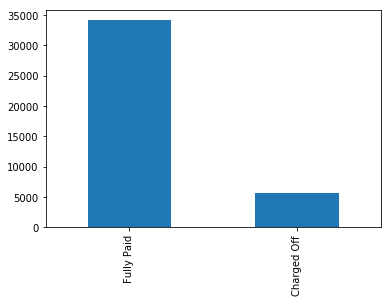

In [6]:
df.loan_status.value_counts().plot(kind='bar')

In [7]:
ax = def_rates_by_categorical(df, 'pub_rec_bankruptcies')

### DTI also a factor

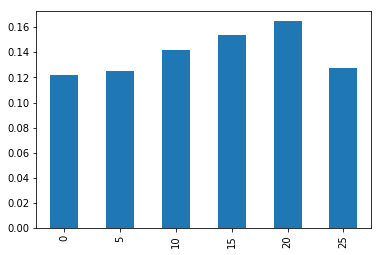

In [8]:
def_by_dti = df.set_index('dti').groupby(by=(lambda x: round_to_nearest(x, 5), 'loan_status'))['loan_amnt'].count().unstack()
def_by_dti = (def_by_dti['Charged Off'] / def_by_dti.sum(axis=1))
ax = def_by_dti.plot(kind = 'bar')

### Small business loans are much riskier

In [9]:
def_rates_by_categorical(df, 'purpose', with_variance=True)

### (Light) Feature Engineering

In [10]:
df_ = df.copy()

domain_columns = ['loan_amnt', 
                  'term', 
                  'annual_inc', 
                  'installment_over_income', 
                  'has_employer_info',
                  'is_employed',
                  'dti',
                  'purpose_is_small_business',
                  'inq_last_6mths',
                  'delinq_2yrs',
                  'open_acc',
                  'int_rate',
                  'revol_util',
                  'pub_rec_bankruptcies',
                  'revol_bal',
                  'requested_minus_funded',
                  'debt_to_income'
                 ]

#features to engineer
df_['requested_minus_funded'] = df_['loan_amnt'] - df_['funded_amnt']
df_['has_employer_info'] = df_['emp_title'].isnull()
df_['installment_over_income'] = df_['installment'] / df_['annual_inc']
df_['is_employed'] = df_['emp_length'].isnull()
df_['debt_to_income'] = (df_['revol_bal'] + df_['funded_amnt']) / df['annual_inc']



#dummy section
dummy_columns = ['home_ownership','purpose', 'grade', 'addr_state']

for column in dummy_columns:
    dummies = pd.get_dummies(df_[column], prefix="{}_is".format(column))
    columns_to_add = dummies.columns.values[:-1]
    dummies = dummies[columns_to_add]
    df_ = df_.join(dummies)
    domain_columns.extend(columns_to_add)

df_['default'] = df_['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
domain_columns = list(set(domain_columns))



### Train/Test Split

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(df_[domain_columns].values)
y = df_['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = .2)

### Train a Logistic Regression

We'll first try out a logistic regression. If the model is performant, explaining its behavior for a given decision, and describing broader relationships between applicant characteristics and default risk is trivial; we can exactly express the model with a few coefficients.

In [12]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression()
reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Lets evaluate how well our regression did:

In [30]:
preds = reg.predict(X_test)
cm = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, classes=['No Default',' Default'],
                      normalize=False,
                      title='Regressor Confusion Matrix on Test Set')
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          0       0.86      1.00      0.92      6839
          1       0.45      0.02      0.03      1119

avg / total       0.80      0.86      0.80      7958



* **Low discriminating power / "Naive Classifier"**
* **Apparent class imbalance problem**
* **need to reweight or resample**

Our regression was not able to discriminate between defaulting and non-defaulting applicants, and appears to be a "Naive" classifier in the sense that simply predicts the majority class. Let's try again, increasing the weight of the minority class:

In [14]:
balanced_reg = LogisticRegression(class_weight='balanced')
balanced_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

             precision    recall  f1-score   support

          0       0.92      0.65      0.76      6839
          1       0.23      0.64      0.34      1119

avg / total       0.82      0.65      0.70      7958



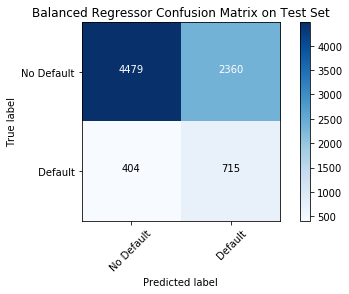

In [31]:
preds = balanced_reg.predict(X_test)
cm = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, classes=['No Default',' Default'],
                      normalize=False,
                      title='Balanced Regressor Confusion Matrix on Test Set')
print(classification_report(y_test, preds))

Naturally, the recall of the defaulted has increased; most loans that Default are predicted as such. However, the precision is very low; most predictions of "Default" will be incorrect. At this point, the researcher must determine the relative costs of false positives and false negatives, and adjust a discriminative threshold accordingly. To help us understand this, we'll vary the threshold to see how well we do on the "Default" class.

In [16]:
ax = plot_roc_curve(y_test, X_test, {'Regression': balanced_reg})

<a href="#ROC-Analysis-across-Models">Performance of other models</a>

* Beginning to get good results
* Begin looking at features

In [17]:
linear_coefs = pd.DataFrame({'value':balanced_reg.coef_[0],
                             'param':domain_columns}).sort_values('value')

is_state = lambda x: bool(re.match('addr_state', x))
is_grade = lambda x: bool(re.match('grade_is', x))
is_other = lambda x: not(is_state(x) or is_grade(x))


states = linear_coefs[linear_coefs['param'].apply(is_state)]
grades = linear_coefs[linear_coefs['param'].apply(is_grade)]
others = linear_coefs[linear_coefs['param'].apply(is_other)]

In [18]:
f, ax = plt.subplots(1, figsize=(16, 7))
others.set_index('param').plot(ax=ax,kind = 'bar')


### What the regression has learned:
* Factors that contribute to default:
    * long term loans
    * high interest rates
    * applicant liquidity/solvency
    * no history of bad behavior
* These all seem reasonable.

* A linear model could be suboptimal if:
    * There is a nonlinear relationship between a variable and the target
    * If there is an interaction between two variables and the target

### Train a feed forward NN

Were going to do some grid search over the number of layers.

In [20]:
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

def create_nn(layer_size, 
              l2_weight, 
              dropout_prob,
              layer_size2, 
              l2_weight2, 
              dropout_prob2):
    
    input_layer = Dense(X.shape[1], 
                    input_dim=X.shape[1], 
                    kernel_initializer='normal', 
                    activation='relu')
    
    hidden_layer1 = Dense(layer_size, 
                    kernel_initializer='normal', 
                    activation='relu',
                    kernel_regularizer=regularizers.l2(l2_weight), 
                   )
    
    dropout1 = Dropout(dropout_prob)
    
    hidden_layer2 = Dense(layer_size2, 
                    input_dim=layer_size,
                    kernel_initializer='normal', 
                    activation='relu',
                    kernel_regularizer=regularizers.l2(l2_weight2), 
                   )
    
    dropout_layer2 = Dropout(dropout_prob2)
    
    output_layer = Dense(1, kernel_initializer='normal', activation='sigmoid')
    
    # create model
    model = Sequential()
    model.add(input_layer)
    model.add(hidden_layer1)
    model.add(dropout1)
    model.add(hidden_layer2)
    model.add(dropout_layer2)    
    model.add(output_layer)
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

class NNPipeline(Pipeline):
    """Inherits sklearn's Pipeline, with keyword args"""
    
    def __init__(self, layer_size=10, n_epochs=None, dropout_prob=.1, l2_weight=.01, layer_size2=10, dropout_prob2=.1, l2_weight2=.01, class_weight='balanced'):
        
        if n_epochs is None:
            n_epochs = 10
        
        def nn_func():
            #create a parameter free generator
            return create_nn(layer_size, 
                             l2_weight, 
                             dropout_prob, 
                             layer_size2, 
                             l2_weight2, 
                             dropout_prob2)
        
        self.layer_size = layer_size
        self.n_epochs = n_epochs
        self.l2_weight = l2_weight
        self.dropout_prob = dropout_prob
        self.layer_size2 = layer_size2
        self.dropout_prob2 = dropout_prob2
        self.l2_weight2 = l2_weight2
        
        nn_estimators = []
        nn_estimators.append(('mlp', KerasClassifier(build_fn=nn_func, 
                                                  epochs=n_epochs, 
                                                  batch_size=5000, 
                                                  verbose=4,
                                                  class_weight = class_weight
                                                 )))        
        
        super(NNPipeline,self).__init__(nn_estimators)
            

In [23]:
# #Grid search over neural networks
# from sklearn.model_selection import GridSearchCV
# parameters = {'layer_size':   [35, 55, 75], 
#               'dropout_prob': [0], #[.01, .1, .2], 
#               'l2_weight':    [.001, .01],
#               'layer_size2':  [10, 35, 55], 
#               'dropout_prob2':[0], #[.01, .1, .2], 
#               'l2_weight2': [.001, .01]
#              }
# gsnn = GridSearchCV(NNPipeline(class_weight=class_weights), parameters)
# gsnn.fit(X_train, y_train)

# ## evaluation cross val tuning results
# ## a good model will consistently do well
# ## on test tests, expected val accu / val accuracy variance

# cv_results = pd.DataFrame(list(gsnn.cv_results_['params']))
# for col in ['split2_test_score', 'split1_test_score', 'split0_test_score', 'mean_test_score','std_test_score']:
#     cv_results[col] = gsnn.cv_results_[col]
    
# cv_results['sharpe'] = cv_results['mean_test_score'] / cv_results['std_test_score']
# cv_results = cv_results.sort_values('sharpe')
# best = cv_results[gsnn.best_params_.keys()].iloc[0]
# params = best.to_dict()

params = {
    'layer_size2': 10.0, 
    'l2_weight2': 0.001, 
    'dropout_prob': 0.0, 
    'l2_weight': 0.001, 
    'dropout_prob2': 0.0, 
    'layer_size': 35.0
}

In [25]:
from keras import callbacks

for key in params:
    if 'layer' in key:
        params[key] = int(params[key])

def nn_func():
    return create_nn(**params)

class_weights = {0: y_train.mean(), 1: 1 - y_train.mean()}

nn = KerasClassifier(build_fn=nn_func, 
                     epochs=100, 
                     batch_size=5000, 
                     verbose=0,
                     callbacks = [callbacks.History(),
                                  callbacks.EarlyStopping(monitor='val_acc', patience=30)],
                     class_weight = class_weights)

history = nn.fit(X_train, y_train, validation_data=(X_validate, y_validate))

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl


### Lets also train a rf

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
# parameters = {"max_depth": [10, None],
#               "max_features": [5, None, 'auto'],
#              'min_samples_leaf':[2, .001]}

# rf = GridSearchCV(
#     RandomForestClassifier(
#         n_estimators = 100, 
#         class_weight='balanced'
#     ), 
#     parameters, 
#     n_jobs = 4
# )
# rf.fit(X_train, y_train)
# rf_params = rf.best_estimator_.get_params()

rf_params = {
    'warm_start': False, 
    'oob_score': False, 
    'n_jobs': 1, 
    'verbose': 0, 
    'max_leaf_nodes': None, 
    'bootstrap': True, 
    'min_samples_leaf': 2, 
    'n_estimators': 100, 
    'min_samples_split': 2, 
    'min_weight_fraction_leaf': 0.0, 
    'criterion': 'gini', 
    'random_state': None, 
    'min_impurity_split': 1e-07, 
    'max_features': None, 
    'max_depth': None, 
    'class_weight': 'balanced'
}

In [29]:
rf_best = RandomForestClassifier(**rf_params)
rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### ROC Analysis across Models

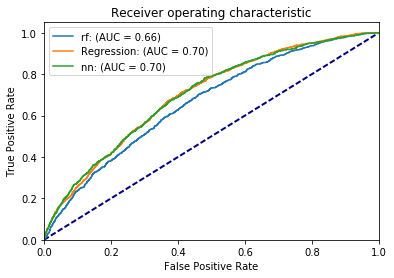

In [33]:
ax = plot_roc_curve(y_test, X_test, {'Regression': balanced_reg, 'nn':nn, 'rf':rf_best})

### Why are these more sophistocated models not doing better?

Lets use skater to explore our models. Recall:

* A linear model could be suboptimal if:
    * There is a nonlinear relationship between a variable and the target
    * If there is an interaction between two variables and the target
    
    
Lets begin looking for a non-linearity or an interaction. Where to start our search? Lets run feature importance to check.

In [34]:
!pip install skater -q

In [35]:
from skater import Interpretation
from skater.model import InMemoryModel
#create skater models for each model

#the neural network
model_nn = InMemoryModel(nn.predict_proba,                     
                         target_names=['Paid off',' Default'], 
                         examples=X_train[:5]                  
                        )

#repeat for other 2 models
model_reg = InMemoryModel(balanced_reg.predict_proba, 
                          target_names=['Paid off',' Default'], 
                          examples=X_train[:5])
model_rf = InMemoryModel(rf_best.predict_proba, 
                         target_names=['Paid off',' Default'], 
                         examples=X_train[:5])

#now lets create an interpretation object
interpreter = Interpretation(X_train, log_level=100000,
                             feature_names=domain_columns)


### Feature importance (top 20)

In [36]:
#get feature importance values
reg_importances = interpreter.feature_importance.feature_importance(model_reg)
rf_importances = interpreter.feature_importance.feature_importance(model_rf)
nn_importances = interpreter.feature_importance.feature_importance(model_nn)

# we could also plot with: 
# interpreter.feature_importance.plot_feature_importance(model_rg)

[88/88] features ████████████████████ Time elapsed: 81 seconds

In [38]:

importances = pd.DataFrame(
    {
        'nn_importance':nn_importances,
        'rf_importance':rf_importances,
        'reg_importance':reg_importances
    }
)

importances['mean'] = importances.mean(axis=1)
importances = importances.sort_values('mean').reset_index().tail(25)

x = 'nn_importance'
y = 'rf_importance'
val = 'index'

ax = importances.plot(kind = 'scatter', x = x, y = y, figsize=(16, 7))
        
for i, point in importances.tail(10).iterrows():
    ax.text(point[x], point[y], str(point[val]))
    
ax.set_title("Feature importances for non-linear models")
ax.plot(ax.get_xticks(), ax.get_xticks(), linestyle = "--")

Most relevant features:
* interest rate
* annual income
* credit utilization
* term
* debt to income
* inq_last_6mnths

[9/9] grid cells ████████████████████ Time elapsed: 3 secondsnds

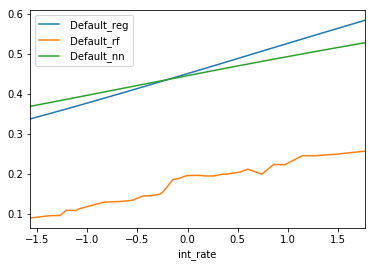

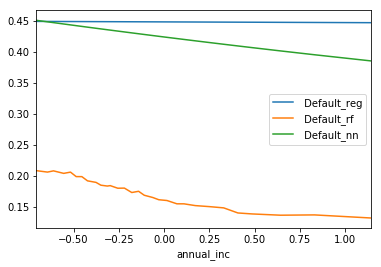

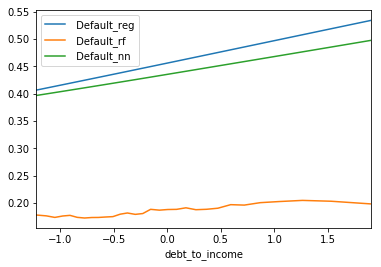

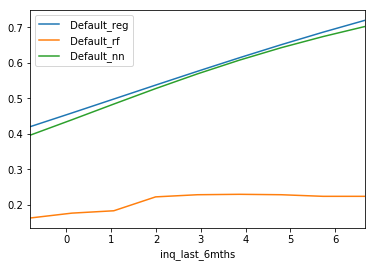

In [39]:
top_features = ['int_rate','annual_inc','revol_util','term','debt_to_income', 'inq_last_6mths']
models = {'nn':nn, 'rf':rf_best, 'reg':balanced_reg}


for feature in top_features:
    pd_rf = interpreter.partial_dependence.partial_dependence([feature], model_rf, n_samples=500).set_index(feature)
    pd_reg = interpreter.partial_dependence.partial_dependence([feature], model_reg, n_samples=500).set_index(feature)
    pd_nn = interpreter.partial_dependence.partial_dependence([feature], model_nn, n_samples=500).set_index(feature)
    
    pd_rf.columns = [i + "_rf" for i in pd_rf.columns]
    pd_reg.columns = [i + "_reg" for i in pd_reg.columns]
    pd_nn.columns = [i + "_nn" for i in pd_nn.columns]
    
    
    pd_reg.join(pd_rf).join(pd_nn)[[' Default_reg',' Default_rf', ' Default_nn']].plot()

Though the random forest seems to generally return lower probabilities (translated down), it looks like all the models learned approximately linear relationships among the top features! Lets check a couple features for interactions.

In [ ]:
%matplotlib notebook

[900/900] grid cells ████████████████████ Time elapsed: 188 seconds

[[<matplotlib.figure.Figure at 0x7fcd682ffa90>,

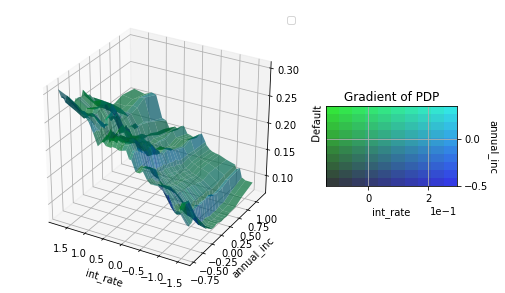

In [40]:
interpreter.partial_dependence.plot_partial_dependence([('int_rate', 'annual_inc')], 
                                                      model_rf, 
                                                      n_samples=500, 
                                                      figsize=(8, 5))

[900/900] grid cells ████████████████████ Time elapsed: 509 seconds

[[<matplotlib.figure.Figure at 0x7fcd6a0d1490>,

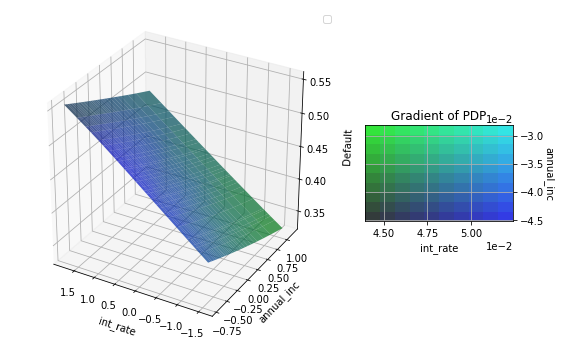

In [50]:
interpreter.partial_dependence.plot_partial_dependence([('int_rate', 'annual_inc')], 
                                                       model_nn, 
                                                       n_samples=200, 
                                                       figsize = (9, 6))

It looks as if the more complex models arent much more than learning what the regression learned!

### Exercise:

Try training your own model (KNearestNeighbors, SVM, XGBoost, etc). Determine if:

A) it outperforms any of the existing models by plotting ROC with `plot_roc_curve(y_test, X_test, model_dictionary)`

B) Compare your model's variable importance with those the existing models with `interpreter.feature_importance.feature_importance(model)`.

C) Explore how your new model relates `int_rate` with default by using `interpreter.partial_dependence.partial_dependence(['int_rate'], model)`

In [41]:
# import and instantiate an sklearn model here
#from sklearn import  
#mymodel 
mymodel.fit(X_train, y_train)

# plot ROC
plot_roc_curve(y_test, X_test, {'mymodel':mymodel, 'nn':nn, 'rf': rf})

In [42]:
# # feature importance
# my_skater_model = InMemoryModel(mymodel)


In [43]:
# partial depedence
interpreter.partial_dependence.plot_partial_dependence(figsize=(10, 6))

### Exploring Individual Predictions

In [58]:
preds = model_rf(X_train)[:, 1]
i0 = preds.argmin()
i1 = preds.argmax()

In [59]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X, feature_names=domain_columns, discretize_continuous=False)

Because regression coefficients are fixed for any point, the explanation for 2 separate individuals looks the same:

In [60]:
explainer.explain_instance(X_train[i0], model_reg).show_in_notebook()

In [61]:
explainer.explain_instance(X_train[i1], model_reg).show_in_notebook()

If the random forest were highly non-linear, then explanations across points would look **different**. Anecdotally, they appear equivalent:

In [62]:
explainer.explain_instance(X_train[i0], model_rf).show_in_notebook()

In [63]:
explainer.explain_instance(X_train[i1], model_rf).show_in_notebook()

### Comparing LIME across 3 Models with 3D scatter plots:

In [44]:
from sklearn.linear_model import LinearRegression
def to_explanation(explainer, models, row):
    results = {}
    for model_name, model in models.items():
        
        explanation = explainer.explain_instance(row, model, model_regressor=LinearRegression(), num_features=100)
        features, vals = list(zip(*explanation.as_list()))
        results[model_name] = pd.Series(vals, index=features)
    
    results = pd.DataFrame(results)
    results['mean_absolute'] = results.abs().mean(axis=1)
    return results.sort_values('mean_absolute', ascending=False)

In [45]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
i = 13
params = to_explanation(explainer, {'rf':model_rf, 'nn':model_nn, 'reg':model_reg}, X[i])
params = params.loc[top_features]
ax.scatter3D(params.rf, params.reg, zs=params.nn)
ax.plot3D(ax.get_xticks(), ax.get_xticks(), ax.get_xticks(), linestyle = "--")
ax.set_xlabel("rf")
ax.set_ylabel("reg")
ax.set_zlabel("nn")
ax.set_title("LIME Regression Coefficients for Individual #{}".format(i))

<IPython.core.display.Javascript object>